# COMP 4949 Assignment 2 - Toxicity Detection Model Development

This notebook demonstrates the incremental development of text toxicity detection model, showing the process of feature engineering, model selection, and evaluation.

## Data Information

The Civil Comments dataset was collected from a comment moderation platform that operated from 2015 to 2017 across various independent news websites. During the platform's operation, readers would rate comments based on their civility, creating a robust dataset of human-labeled text. The dataset was subsequently published by Jigsaw (a unit of Google) for research purposes related to content moderation and toxicity detection. It contains approximately 2 million comments with human annotations for toxicity, severe toxicity, and identity-based attacks, making it a valuable resource for developing machine learning models to identify harmful content online.

The original dataset can be found here: 

[Hugging Face](https://huggingface.co/datasets/google/civil_comments)

[Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data)

In [19]:
# ===============================
# Install Requirements (Run this first)
# ===============================
# !pip install datasets scikit-learn pandas joblib matplotlib seaborn

# ===============================
# Imports
# ===============================
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re

## 1. Data Loading and Exploration

The dataset uses 100,000 comments* selected from the `civil_comments` dataset with 8 columns, including various toxicity measures.

- text
- toxicity
- severe_toxicity
- obscene
- threat
- insult
- identity_attack
- sexual_explicit

There are no missing values in any columns. 
```
Missing values:
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64
```

To better capture whether a comment is toxic in any way, a new column max_toxicity was created. This value represents the maximum toxicity score across all seven toxicity-related features (toxicity, severe_toxicity, obscene, threat, insult, identity_attack, and sexual_explicit).
This approach ensures that if a comment is highly toxic under any category, it is properly flagged.

The toxicity score distribution is heavily skewed, with a mean of 0.1059 and median of 0.0, indicating that most comments are non-toxic. 
```
Max Toxicity score distribution:
count    100000.000000
mean          0.105910
std           0.197798
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: max_toxicity, dtype: float64

```

When using a threshold of 0.5 to classify comments as toxic, only 8.23% (8230) of comments are labeled as toxic, while 91.77% (91,770) are non-toxic. This significant class imbalance is important to consider during model development, as it will require techniques like class weighting or threshold optimization to effectively detect toxic comments without excessive false positives.

```
Class distribution based on max toxicity score:
Non-toxic (0): 91770 (91.77%)
Toxic (1): 8230 (8.23%)
```

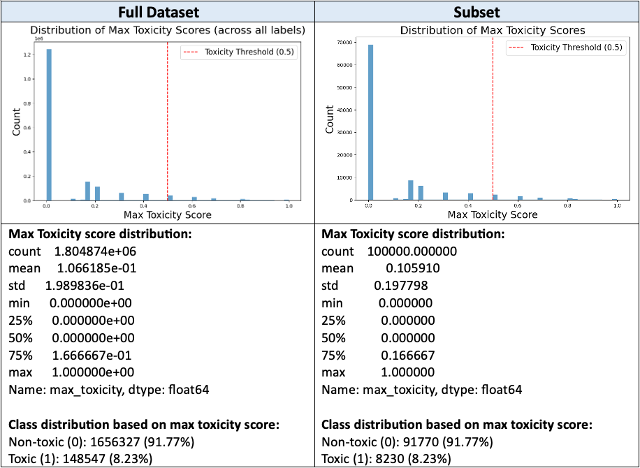

*NOTE: The dataset used in this notebook is a subset of the original dataset, containing 100,000 comments. The original dataset contains 2 million comments. The subset was created to reduce the computational load and speed up the training process. The subset is still representative of the original dataset, as it contains a similar distribution of toxic and non-toxic comments.

In [ ]:
# ===============================
# Original Dataset For Comparison
# ===============================

# Load the original dataset
print("Loading full dataset...")
dataset = load_dataset("civil_comments", split="train")
df = pd.DataFrame(dataset)

# Examine dataset structure
print("Dataset shape:", df.shape)
print("\nDataset columns:")
for col in df.columns:
    print(f"- {col}")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# ===============================
# Create new toxicity score: max across all labels
# ===============================

# Define toxicity-related labels
LABELS = [
    "toxicity",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
    "sexual_explicit"
]

# New column: maximum toxicity across all 7 labels
df['max_toxicity'] = df[LABELS].max(axis=1)

# ===============================
# Investigate toxicity distribution
# ===============================

print("\nMax Toxicity score distribution:")
print(df['max_toxicity'].describe())

# ===============================
# Create new target: Toxic in ANY way
# ===============================

# Toxic if max toxicity ≥ 0.5
df['target'] = (df['max_toxicity'] >= 0.5).astype(int)

# Print class distribution
print("\nClass distribution based on max toxicity score:")
class_counts = np.bincount(df['target'])
print(f"Non-toxic (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Toxic (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")

# ===============================
# Visualize max toxicity score distribution
# ===============================

plt.figure(figsize=(10, 6))
plt.hist(df['max_toxicity'], bins=50, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--',
            label='Toxicity Threshold (0.5)')
plt.title('Distribution of Max Toxicity Scores (across all labels)', fontsize=22)
plt.xlabel('Max Toxicity Score', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [21]:
# ===============================
# Load and Sample Dataset with Stratification
# ===============================

print("Loading full dataset...")
# Load the full dataset
full_dataset = load_dataset("civil_comments", split="train")
print(f"Full dataset size: {len(full_dataset)} comments")

# Convert to pandas DataFrame
df_full = pd.DataFrame(full_dataset)

# Define toxicity-related labels
LABELS = [
    "toxicity", 
    "severe_toxicity", 
    "obscene", 
    "threat", 
    "insult", 
    "identity_attack", 
    "sexual_explicit"
]

# Create a new column for maximum toxicity score across all labels
df_full['max_toxicity'] = df_full[LABELS].max(axis=1)

# Create binary target: toxic if max toxicity >= 0.5
df_full['is_toxic'] = (df_full['max_toxicity'] >= 0.5).astype(int)

# Check class distribution in full dataset
full_class_counts = np.bincount(df_full['is_toxic'])
print(f"\nFull dataset - Non-toxic: {full_class_counts[0]} ({full_class_counts[0]/len(df_full)*100:.2f}%)")
print(f"Full dataset - Toxic: {full_class_counts[1]} ({full_class_counts[1]/len(df_full)*100:.2f}%)")

# ===============================
# Stratified Sampling
# ===============================

# Use stratified sampling to get 100,000 comments
subset_size = 100000
test_size = 1 - (subset_size / len(df_full))

print(f"\nTaking stratified sample of {subset_size} comments...")
df_subset, _ = train_test_split(
    df_full,
    test_size=test_size,
    random_state=42,
    stratify=df_full['is_toxic']
)

# Final dataframe
df = df_subset.copy()

print(f"\nSubset size: {len(df)} comments")

# Check class distribution in subset
subset_class_counts = np.bincount(df['is_toxic'])
print(f"Subset - Non-toxic: {subset_class_counts[0]} ({subset_class_counts[0]/len(df)*100:.2f}%)")
print(f"Subset - Toxic: {subset_class_counts[1]} ({subset_class_counts[1]/len(df)*100:.2f}%)")

# ===============================
# Dataset Exploration
# ===============================

print("\nDataset shape:", df.shape)
print("\nDataset columns:")
for col in df.columns:
    print(f"- {col}")

print("\nMissing values:")
print(df.isnull().sum())

# Toxicity distribution for max toxicity
print("\nMax Toxicity score distribution:")
print(df['max_toxicity'].describe())

# Create final 'target' based on max_toxicity
df['target'] = (df['max_toxicity'] >= 0.5).astype(int)

# Check final class distribution
class_counts = np.bincount(df['target'])
print("\nClass distribution based on max toxicity score:")
print(f"Non-toxic (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Toxic (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")

# ===============================
# Visualization
# ===============================

plt.figure(figsize=(10, 6))
plt.hist(df['max_toxicity'], bins=50, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Toxicity Threshold (0.5)')
plt.title('Distribution of Max Toxicity Scores', fontsize=22)
plt.xlabel('Max Toxicity Score', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize=16)
plt.show()

# ===============================
# Example Comments
# ===============================

print("\nExample toxic comments:")
for text in df[df['target'] == 1]['text'].sample(3, random_state=42).values:
    print(f"- {text[:100]}...")

print("\nExample non-toxic comments:")
for text in df[df['target'] == 0]['text'].sample(3, random_state=42).values:
    print(f"- {text[:100]}...")

## 2. Text Preprocessing

Text preprocessing is essential in toxic comment detection because it cleans and standardizes raw text for machine learning. Removing irrelevant elements like URLs and HTML tags reduces noise, while converting text to lowercase ensures consistency. By focusing on meaningful patterns instead of superficial differences, preprocessing improves model performance and makes it more reliable across different types of comments.

Here is an example of the original text and the preprocessed text:
```
Original text:
When Trudeau is unscripted, he is an utter fool.
And an embarrassment.

Cleaned text:
when trudeau is unscripted he is an utter fool
and an embarrassment
```

In [22]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Keep alphanumeric, spaces, and some punctuation
    text = re.sub(r'[^\w\s!@#$%^&*()]', '', text)
    
    return text

# Apply preprocessing to all texts
df['clean_text'] = df['text'].apply(preprocess_text)

# Show example of raw vs. cleaned text
sample_idx = df[df['target'] == 1].index[10]
print("Original text:")
print(df.loc[sample_idx, 'text'][:200])
print("\nCleaned text:")
print(df.loc[sample_idx, 'clean_text'][:200])

Original text:
Dumbest travel company ever! I don't need to be traveling to places where I need government-assigned escort.

Cleaned text:
dumbest travel company ever! i dont need to be traveling to places where i need governmentassigned escort


## 3. Train-Test Split

Split the data into training and testing sets using stratification to maintain class balance.

Stratification is crucial when dealing with class imbalance, like in our dataset where only 8% of comments are toxic. It ensures that both training and testing sets reflect the original class proportions. Without it, random sampling could lead to too few toxic examples in either set, hurting model training and evaluation. Maintaining this balance is key to building reliable toxicity detection models that perform well in real-world settings where toxic content is rare.

In [23]:
# Split data into training and testing sets
X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

print(f"Training distribution: {np.bincount(y_train)}")
print(f"Testing distribution: {np.bincount(y_test)}")

Training set: 80000 samples
Testing set: 20000 samples
Training distribution: [73416  6584]
Testing distribution: [18354  1646]


## 4. Feature Engineering - Approach 1: Word-Based Features

First, word-based TF-IDF (Term Frequency-Inverse Document Frequency) features were used to convert text into numerical representations for machine learning models. By extracting unigrams and bigrams, this approach highlights distinctive toxic terms such as insults, slurs, and threats, while down-weighting common words.

To improve efficiency and reduce overfitting, the vectorizer was configured to select the 10,000 most relevant features, filtering out extremely rare or frequent terms. While effective at capturing explicit toxicity, this method may miss subtler patterns better detected by character-level analysis.

```
Word feature matrix shape: (80000, 10000)

Word-Based Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     18354
           1       0.35      0.68      0.46      1646

    accuracy                           0.87     20000
   macro avg       0.66      0.78      0.69     20000
weighted avg       0.92      0.87      0.89     20000

Word-Based Model ROC AUC: 0.8668
```

The classification report shows:
- Class 0 (Non-toxic comments):
    - Very high precision (0.97) and good recall (0.89), leading to a strong F1-score of 0.93.
	- The model does a great job at correctly identifying non-toxic comments.
- Class 1 (Toxic comments):
    - Precision is lower (0.35), meaning the model sometimes incorrectly labels non-toxic comments as toxic.
    - Recall is fairly good (0.68), meaning the model catches many toxic comments but misses some.
    - The F1-score for toxic comments is 0.46, showing there is room for improvement.
- Overall performance:
	- The model reaches 87% accuracy on the validation set.
	- The ROC AUC score is 0.8668, which shows the model is fairly good at telling apart toxic and non-toxic comments.
	- However, the model performs much better for non-toxic comments than for toxic ones, likely because toxic comments are much fewer in the dataset.

**Interpretation**

The model is very good at spotting non-toxic comments but struggles more with detecting toxic ones. It is able to find many toxic comments (good recall), but it also incorrectly flags some non-toxic comments as toxic (low precision).

In [24]:
# Create word-level vectorizer
word_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)  # Unigrams and bigrams
)

# Transform text data to feature vectors
X_train_word = word_vectorizer.fit_transform(X_train)
X_test_word = word_vectorizer.transform(X_test)

print(f"Word feature matrix shape: {X_train_word.shape}")

# Train a logistic regression model on word features
word_model = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=200,
    random_state=42,
    n_jobs=-1
)

word_model.fit(X_train_word, y_train)

# Evaluate on test set
y_pred_word = word_model.predict(X_test_word)
y_proba_word = word_model.predict_proba(X_test_word)[:, 1]

print("\nWord-Based Model Classification Report:")
print(classification_report(y_test, y_pred_word))

# Calculate ROC AUC score
word_auc = roc_auc_score(y_test, y_proba_word)
print(f"Word-Based Model ROC AUC: {word_auc:.4f}")

Word feature matrix shape: (80000, 10000)

Word-Based Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     18354
           1       0.35      0.68      0.46      1646

    accuracy                           0.87     20000
   macro avg       0.66      0.78      0.69     20000
weighted avg       0.92      0.87      0.89     20000

Word-Based Model ROC AUC: 0.8668


## 5. Feature Engineering - Approach 2: Character-Based Features

To complement the word-based approach, character-based TF-IDF features were also used. Instead of relying on full words, this method creates features from sequences of 3 to 5 characters, allowing the model to capture finer patterns within the text.

Character-based features offer several advantages:
- They detect subword patterns that word-based models might miss.
- They are more robust to misspellings, slang, and deliberate obfuscations commonly used to avoid detection.
- They help identify toxic language even when words are creatively modified.

In this approach, the vectorizer extracted the 20,000 most relevant character n-grams, enabling the model to better recognize subtle toxic signals that may not form complete words.

```
Character feature matrix shape: (80000, 20000)

Character-Based Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18354
           1       0.39      0.76      0.51      1646

    accuracy                           0.88     20000
   macro avg       0.68      0.82      0.72     20000
weighted avg       0.93      0.88      0.90     20000

Character-Based Model ROC AUC: 0.9067
```

The classification report shows:
- Class 0 (Non-toxic comments):
    - Very high precision (0.98) and good recall (0.89), resulting in a strong F1-score of 0.93.
	- The model continues to perform very well at identifying non-toxic comments.
- Class 1 (Toxic comments):
    - Precision improves slightly (0.39) compared to the word-based model, and recall is higher (0.76), meaning the model detects even more toxic comments.
	- The F1-score for toxic comments increases to 0.51, showing an improvement in handling the minority toxic class.
- Overall performance:
	- The model reaches 88% accuracy on the validation set.
	- The ROC AUC score improves to 0.9067, showing stronger separation between toxic and non-toxic comments compared to the word-based approach.

**Interpretation**

Character-based features improved the model’s ability to detect toxic comments, especially by capturing subtle patterns and creatively disguised toxic language. The increase in recall and F1-score for the toxic class, along with a higher ROC AUC score, suggests that character-level analysis provides better robustness for real-world text where users might try to bypass simple word-level filters.

In [25]:
# Create character-level vectorizer
char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',  # Character n-grams including word boundaries
    ngram_range=(3, 5),  # Character sequences of length 3-5
    max_features=20000,  # Use more features
    min_df=5,
    max_df=0.7  # Ignore very common character sequences
)

# Transform text data to character feature vectors
X_train_char = char_vectorizer.fit_transform(X_train)
X_test_char = char_vectorizer.transform(X_test)

print(f"Character feature matrix shape: {X_train_char.shape}")

# Train a logistic regression model on character features
char_model = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=200,
    random_state=42,
    n_jobs=-1
)

char_model.fit(X_train_char, y_train)

# Evaluate on test set
y_pred_char = char_model.predict(X_test_char)
y_proba_char = char_model.predict_proba(X_test_char)[:, 1]

print("\nCharacter-Based Model Classification Report:")
print(classification_report(y_test, y_pred_char))

# Calculate ROC AUC score
char_auc = roc_auc_score(y_test, y_proba_char)
print(f"Character-Based Model ROC AUC: {char_auc:.4f}")

Character feature matrix shape: (80000, 20000)

Character-Based Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18354
           1       0.39      0.76      0.51      1646

    accuracy                           0.88     20000
   macro avg       0.68      0.82      0.72     20000
weighted avg       0.93      0.88      0.90     20000

Character-Based Model ROC AUC: 0.9067


## 6. Feature Engineering - Approach 3: Combined Features

The final approach combines both word-level and character-level TF-IDF features to create a more comprehensive representation of the text. This hybrid method:
- Stacks the word and character feature sets horizontally to form a larger feature matrix.
- Leverages the strengths of both approaches: capturing semantic meaning from full words and detecting patterns from character sequences.
- Identifies both explicit toxic terms and more subtle or disguised toxic language.
- Provides the model with more signals to recognize toxicity in different forms.

In this model, the scipy.sparse.hstack function was used to efficiently merge the two sparse matrices without consuming excessive memory. The combined feature matrix enables the classifier to make more nuanced predictions by drawing on both word-level context and character-level patterns.

```
Combined feature matrix shape: (80000, 30000)

Combined Features Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     18354
           1       0.42      0.72      0.53      1646

    accuracy                           0.90     20000
   macro avg       0.70      0.82      0.74     20000
weighted avg       0.93      0.90      0.91     20000

Combined Features Model ROC AUC: 0.9038
```

The classification report shows:
- Class 0 (Non-toxic comments):
	- Very high precision (0.97) and strong recall (0.91), resulting in a high F1-score of 0.94.
	- The model remains highly effective at correctly identifying non-toxic comments.
- Class 1 (Toxic comments):
	- Precision improves to 0.42 and recall remains strong at 0.72, compared to the previous approaches.
	- The F1-score for toxic comments increases to 0.53, showing a more balanced ability to detect toxic content.
- Overall performance:
	- The model reaches 90% accuracy on the validation set.
	- The ROC AUC score is 0.9038, indicating strong discrimination between toxic and non-toxic classes.

**Interpretation**

Combining word-based and character-based features helped further improve the model’s performance, particularly in detecting toxic comments. By capturing both the meaning of full words and the structure of character sequences, the model becomes more robust at identifying a wider range of toxicity, including both explicit language and more subtle or disguised forms.

In [26]:
# Combine word and character features
X_train_combined = hstack([X_train_word, X_train_char])
X_test_combined = hstack([X_test_word, X_test_char])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Train a logistic regression model on combined features
combined_model = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=200,
    random_state=42,
    n_jobs=-1
)

combined_model.fit(X_train_combined, y_train)

# Evaluate on test set
y_pred_combined = combined_model.predict(X_test_combined)
y_proba_combined = combined_model.predict_proba(X_test_combined)[:, 1]

print("\nCombined Features Model Classification Report:")
print(classification_report(y_test, y_pred_combined))

# Calculate ROC AUC score
combined_auc = roc_auc_score(y_test, y_proba_combined)
print(f"Combined Features Model ROC AUC: {combined_auc:.4f}")

Combined feature matrix shape: (80000, 30000)

Combined Features Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     18354
           1       0.42      0.72      0.53      1646

    accuracy                           0.90     20000
   macro avg       0.70      0.82      0.74     20000
weighted avg       0.93      0.90      0.91     20000

Combined Features Model ROC AUC: 0.9038


## 7. Model Comparison

The ROC curves and AUC (Area Under Curve) scores for the three models provide a direct comparison of their ability to distinguish between toxic and non-toxic comments:

```
Model Performance Comparison:
               Model   ROC AUC
1    Character-based  0.906739
2  Combined features  0.903844
0         Word-based  0.866807
```

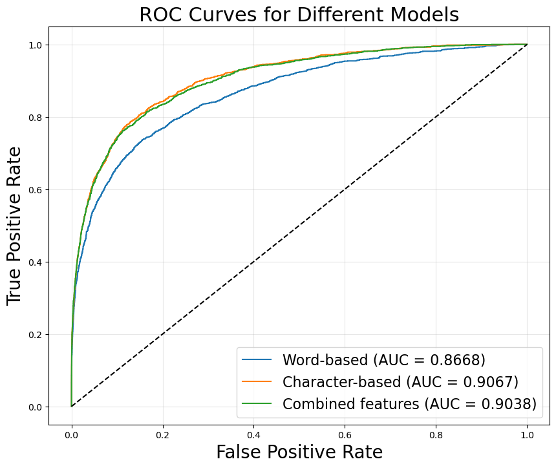

From the ROC curves and AUC scores:
- Character-based model achieved the highest ROC AUC score (0.906739), indicating the best overall performance in distinguishing toxic from non-toxic comments.
- Combined features model performed almost as well, with an AUC of 0.903844. Although slightly lower than the character-based model, it still showed strong performance and better generalization than the word-based model.
- Word-based model had the lowest AUC (0.866807), suggesting it was less effective at separating toxic from non-toxic comments compared to the other two approaches.

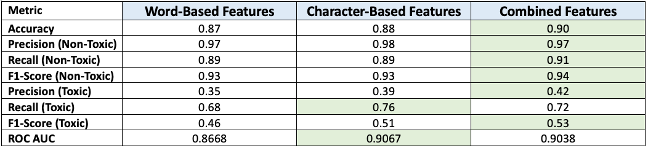

**Interpretation**

The character-based model performed best overall in terms of ROC AUC, likely because it could capture subtle patterns, misspellings, and variations that the word-based model missed.
The combined model also performed strongly by leveraging both the semantic meaning from words and the pattern detection ability from characters.

While the combined model did not outperform the character-based model in ROC AUC, it provided a more balanced and robust approach, especially useful for detecting a wide range of toxic behaviors—from obvious cases to more disguised forms.
Notably, it achieved the highest F1-score for toxic comments (0.53) among all models, showing an improved balance between precision and recall.

Overall, the use of character-level features, either alone or combined with word-level features, clearly led to better toxicity detection performance than relying solely on word-based features.
Given its balanced performance across multiple metrics, the combined features model was selected as the final model for deployment.


In [27]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Word-based model
fpr_word, tpr_word, _ = roc_curve(y_test, y_proba_word)
plt.plot(fpr_word, tpr_word, label=f'Word-based (AUC = {word_auc:.4f})')

# Character-based model
fpr_char, tpr_char, _ = roc_curve(y_test, y_proba_char)
plt.plot(fpr_char, tpr_char, label=f'Character-based (AUC = {char_auc:.4f})')

# Combined model
fpr_combined, tpr_combined, _ = roc_curve(y_test, y_proba_combined)
plt.plot(fpr_combined, tpr_combined, label=f'Combined features (AUC = {combined_auc:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curves for Different Models', fontsize=22)
plt.legend(loc='lower right', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

# Summarize model performance
model_performance = pd.DataFrame({
    'Model': ['Word-based', 'Character-based', 'Combined features'],
    'ROC AUC': [word_auc, char_auc, combined_auc]
})

print("Model Performance Comparison:")
print(model_performance.sort_values('ROC AUC', ascending=False))

## 8. Decision Threshold Optimization

In standard classification models, a default probability threshold of 0.5 is typically used to determine class labels. However, for toxicity detection, optimizing the decision threshold is important because the trade-off between false positives (wrongly flagged content) and false negatives (missed toxic content) can significantly impact real-world applications.

In this project, decision threshold optimization involved:
- Testing multiple probability thresholds ranging from 0.1 to 0.6 in 0.05 increments.
- Evaluating the impact of each threshold on precision (accuracy of toxic predictions) and recall (ability to catch all toxic content).
- Identifying how raising the threshold increases precision but decreases recall.
- Selecting the threshold that best balances these metrics based on the application needs.

```
Threshold Analysis:
   Threshold  Precision    Recall  F1-score  Accuracy
0       0.10   0.143742  0.958688  0.250000   0.52660
1       0.15   0.179409  0.933779  0.300989   0.64305
2       0.20   0.212449  0.893682  0.343291   0.71860
3       0.25   0.247686  0.861482  0.384751   0.77325
4       0.30   0.282803  0.826245  0.421379   0.81325
5       0.35   0.316004  0.801337  0.453265   0.84090
6       0.40   0.350343  0.775820  0.482706   0.86315
7       0.45   0.387410  0.751519  0.511263   0.88175
8       0.50   0.422405  0.719320  0.532254   0.89595
9       0.55   0.455918  0.678615  0.545410   0.90690
```

The threshold analysis shows that as the decision threshold increases, precision steadily improves while recall gradually decreases.
This highlights the typical trade-off: a higher threshold makes toxic predictions more accurate but risks missing more toxic comments, while a lower threshold captures more toxicity but increases false positives.

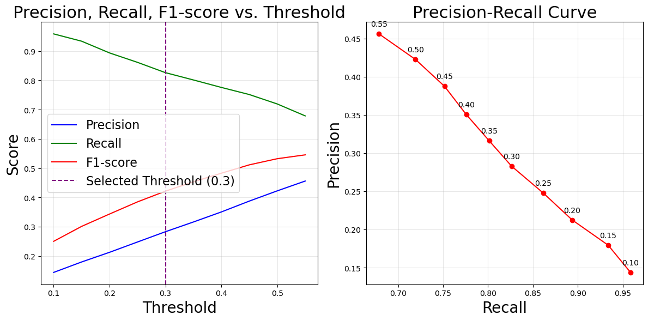

Based on this analysis, a decision threshold of 0.30 was selected for the final model.
At this threshold, the model achieves a strong balance between precision (0.282803) and recall (0.826245), with an F1-score of 0.421379 and an overall accuracy of 81.33%.

For our use case, where the model is intended to flag text that may be not safe for work (NSFW), it is better to be conservative — prioritizing higher recall ensures that most potentially unsafe content is identified, even if it results in some false positives.
Selecting a threshold of 0.30 allows the model to effectively detect the majority of toxic or inappropriate comments, making it more robust and safer for real-world application.

In [28]:
# Choose the best model (combined features)
best_proba = y_proba_combined

# Calculate precision and recall for different thresholds
thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (best_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True)
    
    results.append({
        'Threshold': threshold,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-score': report['1']['f1-score'],
        'Accuracy': report['accuracy']
    })

threshold_df = pd.DataFrame(results)
print("Threshold Analysis:")
print(threshold_df)

# Visualize threshold analysis
plt.figure(figsize=(12, 6))

# Plot precision, recall, F1-score for different thresholds
plt.subplot(1, 2, 1)
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], 'g-', label='Recall')
plt.plot(threshold_df['Threshold'], threshold_df['F1-score'], 'r-', label='F1-score')
plt.axvline(x=0.3, color='purple', linestyle='--', label='Selected Threshold (0.3)')
plt.grid(True, alpha=0.3)
plt.xlabel('Threshold', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Precision, Recall, F1-score vs. Threshold', fontsize=22)
plt.legend(fontsize=16)

# Plot precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(threshold_df['Recall'], threshold_df['Precision'], 'ro-')
for i, threshold in enumerate(threshold_df['Threshold']):
    plt.annotate(f'{threshold:.2f}', 
                 (threshold_df['Recall'][i], threshold_df['Precision'][i]),
                 textcoords="offset points", 
                 xytext=(0, 10),
                 ha='center')
plt.grid(True, alpha=0.3)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve', fontsize=22)

plt.tight_layout()
plt.show()

# Select optimal threshold (e.g., 0.3 based on analysis)
optimal_threshold = 0.3
print(f"\nSelected optimal threshold: {optimal_threshold}")

# Final evaluation with optimal threshold
y_pred_final = (best_proba >= optimal_threshold).astype(int)
print("\nFinal Model Classification Report (with optimal threshold):")
print(classification_report(y_test, y_pred_final))

## 9. Class Imbalance Handling

In this project, SMOTE (Synthetic Minority Over-sampling Technique) was not used to address class imbalance. Instead, alternative strategies that maintain data authenticity while improving model performance were employed:

1. Class Weight Adjustment: The Logistic Regression model was configured with `class_weight='balanced'`, which automatically adjusts the importance of each class inversely proportional to its frequency. This approach ensures that the minority toxic class receives greater attention during model training without artificially altering the data.

2. Threshold Optimization: Instead of relying on synthetic sampling, the model uses decision threshold optimization. By lowering the classification threshold to 0.30, the model improves recall for the toxic class, increasing its sensitivity to minority instances.
	
3. Stratified Sampling: During data splitting, train_test_split was used with the `stratify=y` parameter, preserving the original class distribution in both the training and testing sets to avoid introducing sampling bias.

Although SMOTE could have been applied to create synthetic toxic examples, it might introduce patterns that do not accurately reflect real-world toxic language. The current approach prioritizes maintaining the authenticity of the data while addressing imbalance through model parameters and evaluation strategies.

If future improvements are needed—particularly if the toxic class becomes even rarer—SMOTE could be considered as an enhancement to further support the minority class without severely impacting data integrity.

## 10. Final Model Selection and Testing

After optimizing the model and decision threshold, the final step involved testing the selected configuration on real-world examples to validate its effectiveness.

This process included:
- Testing the model on diverse sample comments representing both toxic and non-toxic content
- Displaying probability scores and classification results for each sample
- Analyzing which specific features (words or character patterns) most influence each prediction
- Confirming that the model behaves as expected on both clear and more nuanced cases

The model was evaluated on a range of sample comments — from clearly positive (“You’re so wonderful”) to explicitly toxic (“waste of oxygen”) to more subtle cases.
For each sample, the model not only predicted the toxicity label but also identified the key word and character features that contributed most to its decision.
This feature attribution provides transparency into the model’s decision-making process and helps ensure that classifications are based on legitimate toxicity indicators rather than irrelevant patterns.

This final testing step served as a quality check before deployment, providing confidence that the model will perform reliably and make reasonable decisions when used in real-world environments.


In [29]:
# Sample comments for final testing
sample_comments = [
    "You're so wonderful and helpful!",
    "You're a complete waste of oxygen.",
    "What a dumb idea. You're clueless.",
    "I appreciate your perspective.",
    "This is the worst presentation I've ever seen.",
    "I disagree with your approach, but I respect your effort."
]

# Preprocess sample comments
preprocessed_samples = [preprocess_text(comment) for comment in sample_comments]

# Extract features
sample_word_features = word_vectorizer.transform(preprocessed_samples)
sample_char_features = char_vectorizer.transform(preprocessed_samples)
sample_combined_features = hstack([sample_word_features, sample_char_features])

# Make predictions with combined model and optimal threshold
sample_probs = combined_model.predict_proba(sample_combined_features)[:, 1]
sample_preds = (sample_probs >= optimal_threshold).astype(int)

print("Sample Comment Predictions:")
print("-" * 80)
for i, (comment, prob, pred) in enumerate(zip(sample_comments, sample_probs, sample_preds)):
    print(f"Comment: {comment}")
    print(f"Probability: {prob:.4f}")
    print(f"Prediction: {'Toxic' if pred == 1 else 'Non-toxic'}")
    
    # Feature analysis for this prediction
    if sample_word_features[i].nnz > 0 or sample_char_features[i].nnz > 0:  # If we have any features
        print("Top contributing features:")
        
        # Word features analysis
        word_indices = sample_word_features[i].nonzero()[1]
        word_names = word_vectorizer.get_feature_names_out()
        word_weights = [(word_names[idx], sample_word_features[i, idx] * combined_model.coef_[0][idx]) for idx in word_indices]
        word_weights = sorted(word_weights, key=lambda x: abs(x[1]), reverse=True)[:3]
        
        if word_weights:
            print("  Word features:")
            for feature, weight in word_weights:
                print(f"    - '{feature}': {weight:.4f}")
        
        # Character features analysis
        char_indices = sample_char_features[i].nonzero()[1]
        char_names = char_vectorizer.get_feature_names_out()
        # Adjust index for combined features (word features come first)
        char_weights = [(char_names[idx], sample_char_features[i, idx] * 
                        combined_model.coef_[0][idx + len(word_names)]) for idx in char_indices]
        char_weights = sorted(char_weights, key=lambda x: abs(x[1]), reverse=True)[:3]
        
        if char_weights:
            print("  Character features:")
            for feature, weight in char_weights:
                print(f"    - '{feature}': {weight:.4f}")
    
    print("-" * 80)

Sample Comment Predictions:
--------------------------------------------------------------------------------
Comment: You're so wonderful and helpful!
Probability: 0.1069
Prediction: Non-toxic
Top contributing features:
  Word features:
    - 'youre': 0.6345
    - 'helpful': -0.2745
    - 'so': -0.1883
  Character features:
    - 'erf': 0.1708
    - 'oure ': 0.1099
    - 'ul ': 0.1021
--------------------------------------------------------------------------------
Comment: You're a complete waste of oxygen.
Probability: 0.7813
Prediction: Toxic
Top contributing features:
  Word features:
    - 'youre': 0.6006
    - 'waste of': 0.5747
    - 'complete': 0.4128
  Character features:
    - ' a ': 0.2647
    - 'plet': 0.2263
    - 'ast': 0.1719
--------------------------------------------------------------------------------
Comment: What a dumb idea. You're clueless.
Probability: 0.9998
Prediction: Toxic
Top contributing features:
  Word features:
    - 'dumb': 2.6315
    - 'youre': 0.5820


## 10. Model Finalization and Saving

The final step in the project involved preparing the trained toxicity detection model for deployment in the Flask application.

This process included:
- Exporting the trained model and vectorizers as serialized files using joblib.
- Preserving all components necessary for preprocessing new text and making predictions.
- Documenting key model details and performance metrics for future reference.
- Creating files that can be easily loaded into the Flask application.

In the implementation, three essential components were saved:
- The combined logistic regression model: toxic_comment_model_logistic_regression.pkl
- The word-level TF-IDF vectorizer: toxic_word_vectorizer.pkl
- The character-level TF-IDF vectorizer: toxic_char_vectorizer.pkl

These saved files are directly compatible with the Flask application’s app.py script, ensuring that the deployed app uses the exact same preprocessing and modeling pipeline as during training.

Additionally, a reference document was generated, containing key information such as feature counts, the decision threshold (0.30), and performance metrics.
This documentation supports model governance, reproducibility, and ongoing maintenance.


In [30]:
# Save final model and vectorizers
joblib.dump(combined_model, "toxic_comment_model_logistic_regression.pkl")
joblib.dump(word_vectorizer, "toxic_word_vectorizer.pkl")
joblib.dump(char_vectorizer, "toxic_char_vectorizer.pkl")

print("Model and vectorizers saved successfully.")
print("\nFinal Model Summary:")
print(f"- Type: Logistic Regression with combined word and character features")
print(f"- Word features: {len(word_vectorizer.get_feature_names_out())} features")
print(f"- Character features: {len(char_vectorizer.get_feature_names_out())} features")
print(f"- Decision threshold: {optimal_threshold}")
print(f"- ROC AUC score: {combined_auc:.4f}")

# Write model details to a file for reference
with open("model_details.txt", "w") as f:
    f.write("Toxicity Detection Model Details\n")
    f.write("===============================\n\n")
    f.write(f"Model Type: Logistic Regression with combined word and character features\n")
    f.write(f"Word features: {len(word_vectorizer.get_feature_names_out())} features\n")
    f.write(f"Character features: {len(char_vectorizer.get_feature_names_out())} features\n")
    f.write(f"Decision threshold: {optimal_threshold}\n")
    f.write(f"ROC AUC score: {combined_auc:.4f}\n\n")
    f.write("Model Performance with Different Feature Types:\n")
    f.write(f"- Word-based model AUC: {word_auc:.4f}\n")
    f.write(f"- Character-based model AUC: {char_auc:.4f}\n")
    f.write(f"- Combined features model AUC: {combined_auc:.4f}\n")

print("\nModel details saved to 'model_details.txt'")

Model and vectorizers saved successfully.

Final Model Summary:
- Type: Logistic Regression with combined word and character features
- Word features: 10000 features
- Character features: 20000 features
- Decision threshold: 0.3
- ROC AUC score: 0.9038

Model details saved to 'model_details.txt'
